Success Probability: 4.6316e-01
Relative Error: 2.9677e-02


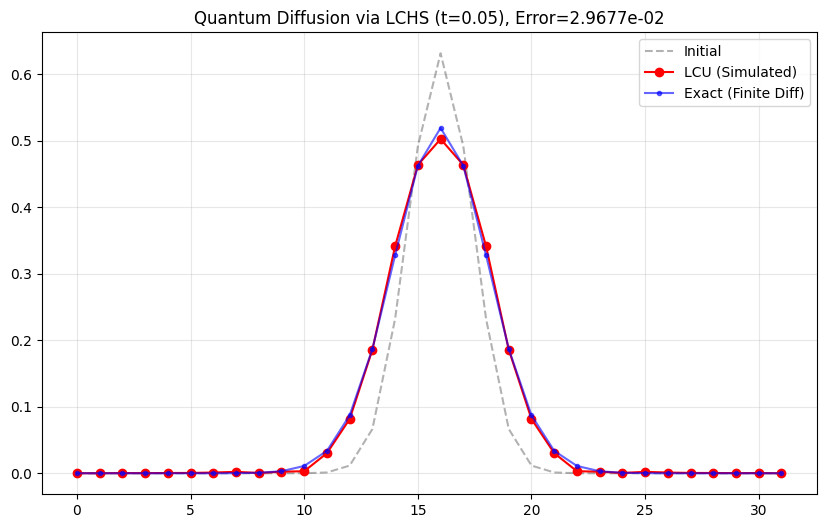

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import DiagonalGate, QFTGate, StatePreparation
from qiskit.quantum_info import Statevector
from scipy.linalg import expm

# Parameters
D = 1
n_qubits = 5
N = 2**n_qubits
L = 2 * np.pi               
t = 0.05            
final_time = t
eps_quad = 1e-10
c = 0.5
num_terms = 64

# Hamiltonian
j_indices = np.arange(N)
k_indices = np.where(j_indices <= N/2, j_indices, j_indices - N)
Hamiltonian_diag = D * (2 * np.pi / L)**2 * (k_indices**2)

# LCHS Parameters 
norm = t * np.linalg.norm(Hamiltonian_diag, np.inf) # Use infinity norm for spectral bound?
h = np.pi / (norm/2 + np.log(64*np.exp(3*c/2)/(15*eps_quad)))
R = (num_terms/2) * h
gamma = np.sqrt(R/(2*c))
J = R/h

# LCU terms
n_ancilla = int(np.log2(num_terms))

# Compute Complex Weights
# x corresponds to the integration variable 'k' in the paper
x = np.linspace(-J, J, num_terms)

weights = (h / np.sqrt(2*np.pi)) * np.exp(c*(1-1j*x)) * np.exp(-(x**2+1)/(4*gamma**2)) / (1 + x**2)

# 2. SEPARATE Magnitude and Phase 
magnitudes = np.abs(weights)
phases = np.angle(weights)

# 3. Prepare Amplitudes 
coeffs = np.sqrt(magnitudes)
coeffs = coeffs / np.linalg.norm(coeffs)         

# Build Circuit
reg_a = QuantumRegister(n_ancilla, 'ancilla') 
reg_s = QuantumRegister(n_qubits, 'system')
lc_qc = QuantumCircuit(reg_a, reg_s)

# PREP (Encodes magnitudes only)
prep_gate = StatePreparation(coeffs)
lc_qc.append(prep_gate, reg_a)

# SELECT (Encodes Unitary AND Phase)
for i in range(num_terms):
    # U(t; k) = exp(-i * k * H * t)
    # We multiply by the weight phase here: e^{i arg(w)} * U
    U_diag = np.exp(1j * phases[i]) * np.exp(-1j * final_time * Hamiltonian_diag * x[i])
    
    # Qiskit endianness: format(i,...) puts LSB on right. 
    # DiagonalGate control matches this convention if applied correctly.
    ctrl_str = format(i, f'0{n_ancilla}b') 
    gate = DiagonalGate(U_diag).control(n_ancilla, ctrl_state=ctrl_str)
    lc_qc.append(gate, list(reg_a) + list(reg_s))

# PREP Dagger (Uncompute)
lc_qc.append(prep_gate.inverse(), reg_a)

# Full Simulation Circuit
circuit = QuantumCircuit(n_ancilla + n_qubits)

# Initialize System (Gaussian)
x_index = np.arange(N)
sigma = 1
state = np.exp(-0.25*((x_index-N/2)/sigma)**2)
state = state / np.linalg.norm(state)
stateprep = StatePreparation(state)
circuit.append(stateprep, range(n_ancilla, n_ancilla + n_qubits))

# QFT -> LCU (Momentum Space) -> IQFT
circuit.append(QFTGate(n_qubits), range(n_ancilla, n_ancilla + n_qubits))
circuit.compose(lc_qc, inplace=True)
circuit.append(QFTGate(n_qubits).inverse(), range(n_ancilla, n_ancilla + n_qubits))

# Simulation
final_state = Statevector(circuit)
full_data = np.array(final_state)

# Post-selection
system_state = full_data[0::2**n_ancilla]

# Normalize & Compare
success_prob = np.linalg.norm(system_state)**2
final = system_state / np.linalg.norm(system_state)

# Exact Solution (Finite Difference Approximation)
dx = L / N
A = (np.diag(-2 * np.ones(N)) + 
     np.diag(1 * np.ones(N - 1), 1) + 
     np.diag(1 * np.ones(N - 1), -1))
A[0, N - 1] = 1
A[N - 1, 0] = 1
A = D * A / (dx**2)

exact_final = expm(A * final_time) @ state
exact_final = exact_final / np.linalg.norm(exact_final)

# Error Calculation
err = np.linalg.norm(np.abs(exact_final) - np.abs(final))

print(f"Success Probability: {success_prob:.4e}")
print(f"Error: {err:.4e}")

plt.figure(figsize=(10, 6))
plt.plot(np.arange(N), state, 'k--', label='Initial', alpha=0.3)
plt.plot(np.arange(N), np.abs(final), 'ro-', label=f'LCU (Simulated)')
plt.plot(np.arange(N), np.abs(exact_final), 'b.-', label='Exact (Finite Diff)', alpha=0.6)
plt.title(f"Quantum Diffusion via LCHS (t={t}), Error={err:.4e}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

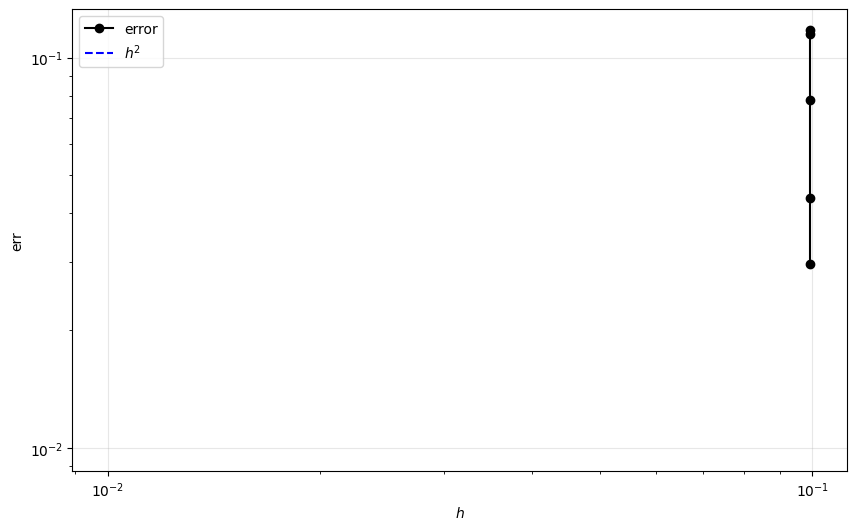

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import DiagonalGate, QFTGate, StatePreparation
from qiskit.quantum_info import Statevector
from scipy.linalg import expm




num_terms_v = [4,8,16,32,64]
errs = []
hs = []
for num_terms in num_terms_v:

        # Parameters
    D = 1
    n_qubits = 5
    N = 2**n_qubits
    L = 2 * np.pi               
    t = 0.05            
    final_time = t
    eps_quad = 1e-10
    c = 0.5

    # Hamiltonian (Laplacian in k-space)
    j_indices = np.arange(N)
    k_indices = np.where(j_indices <= N/2, j_indices, j_indices - N)
    Hamiltonian_diag = D * (2 * np.pi / L)**2 * (k_indices**2)

    # LCHS Parameters 
    norm = t * np.linalg.norm(Hamiltonian_diag, np.inf) # Use infinity norm for spectral bound?
    h = np.pi / (norm/2 + np.log(64*np.exp(3*c/2)/(15*eps_quad)))
    R = (num_terms/2) * h
    gamma = np.sqrt(R/(2*c))
    J = R/h

    # LCU terms
    n_ancilla = int(np.log2(num_terms))

    # 1. Compute Complex Weights 
    # x corresponds to the integration variable 'k' in the paper
    x = np.linspace(-J, J, num_terms)

    weights = (h / np.sqrt(2*np.pi)) * np.exp(c*(1-1j*x)) * np.exp(-(x**2+1)/(4*gamma**2)) / (1 + x**2)

    # 2. SEPARATE Magnitude and Phase 
    magnitudes = np.abs(weights)
    phases = np.angle(weights)

    # 3. Prepare Amplitudes 
    coeffs = np.sqrt(magnitudes)
    coeffs = coeffs / np.linalg.norm(coeffs)         

    # Build Circuit
    reg_a = QuantumRegister(n_ancilla, 'ancilla') 
    reg_s = QuantumRegister(n_qubits, 'system')
    lc_qc = QuantumCircuit(reg_a, reg_s)

    # PREP (Encodes magnitudes only)
    prep_gate = StatePreparation(coeffs)
    lc_qc.append(prep_gate, reg_a)

    # SELECT (Encodes Unitary AND Phase)
    for i in range(num_terms):
        # U(t; k) = exp(-i * k * H * t)
        # We multiply by the weight phase here: e^{i arg(w)} * U
        U_diag = np.exp(1j * phases[i]) * np.exp(-1j * final_time * Hamiltonian_diag * x[i])
        
        # Qiskit endianness: format(i,...) puts LSB on right. 
        # DiagonalGate control matches this convention if applied correctly.
        ctrl_str = format(i, f'0{n_ancilla}b') 
        gate = DiagonalGate(U_diag).control(n_ancilla, ctrl_state=ctrl_str)
        lc_qc.append(gate, list(reg_a) + list(reg_s))

    # PREP Dagger (Uncompute)
    lc_qc.append(prep_gate.inverse(), reg_a)

    # Full Simulation Circuit
    circuit = QuantumCircuit(n_ancilla + n_qubits)

    # Initialize System (Gaussian)
    x_index = np.arange(N)
    sigma = 1
    state = np.exp(-0.25*((x_index-N/2)/sigma)**2)
    state = state / np.linalg.norm(state)
    stateprep = StatePreparation(state)
    circuit.append(stateprep, range(n_ancilla, n_ancilla + n_qubits))

    # QFT -> LCU (Momentum Space) -> IQFT
    circuit.append(QFTGate(n_qubits), range(n_ancilla, n_ancilla + n_qubits))
    circuit.compose(lc_qc, inplace=True)
    circuit.append(QFTGate(n_qubits).inverse(), range(n_ancilla, n_ancilla + n_qubits))

    # Simulation
    final_state = Statevector(circuit)
    full_data = np.array(final_state)

    # Post-selection
    system_state = full_data[0::2**n_ancilla]

    # Normalize & Compare
    success_prob = np.linalg.norm(system_state)**2
    final = system_state / np.linalg.norm(system_state)

    # Exact Solution (Finite Difference Approximation)
    dx = L / N
    A = (np.diag(-2 * np.ones(N)) + 
        np.diag(1 * np.ones(N - 1), 1) + 
        np.diag(1 * np.ones(N - 1), -1))
    A[0, N - 1] = 1
    A[N - 1, 0] = 1
    A = D * A / (dx**2)

    exact_final = expm(A * final_time) @ state
    exact_final = exact_final / np.linalg.norm(exact_final)

    # Error Calculation
    err = np.linalg.norm(np.abs(exact_final) - np.abs(final))

    #err = np.linalg.norm(exact_final-final.real)
    errs.append(err)
    hs.append(h)

plt.figure(figsize=(10, 6))
plt.loglog(hs, errs, 'ok-', label="error")
plt.loglog(hs, np.array(hs)**2, 'b--', label="$h^2$")
plt.xlabel("$h$")
plt.ylabel("err")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import DiagonalGate, QFTGate, StatePreparation
from qiskit.quantum_info import Statevector
from scipy.linalg import expm




num_terms_v = [4,8,16,32,64,128]
errs = []
hs = [2,1,0.5,0.25,0.125,0.0625]
jj=0
for num_terms in num_terms_v:

    D = 1
    n_qubits = 5
    N = 2**n_qubits
    L = 2 * np.pi               
    t = 0.05            
    final_time = t
    #eps_quad = 1e-10
    c = 0.5

    # Hamiltonian (Laplacian in k-space)
    j_indices = np.arange(N)
    k_indices = np.where(j_indices <= N/2, j_indices, j_indices - N)
    Hamiltonian_diag = D * (2 * np.pi / L)**2 * (k_indices**2)

    # LCHS Parameters 
    norm = t * np.linalg.norm(Hamiltonian_diag, np.inf) # Use infinity norm for spectral bound?
    h = hs[jj]
    R = (num_terms/2) * h
    gamma = np.sqrt(R/(2*c))
    J = R/h

    # LCU terms
    n_ancilla = int(np.log2(num_terms))

    # 1. Compute Complex Weights (Eq. 56 / Eq. 6)
    # x corresponds to the integration variable 'k' in the paper
    x = np.linspace(-J, J, num_terms)

    weights = (h / np.sqrt(2*np.pi)) * np.exp(c*(1-1j*x)) * np.exp(-(x**2+1)/(4*gamma**2)) / (1 + x**2)

    # 2. SEPARATE Magnitude and Phase 
    magnitudes = np.abs(weights)
    phases = np.angle(weights)

    # 3. Prepare Amplitudes 
    coeffs = np.sqrt(magnitudes)
    coeffs = coeffs / np.linalg.norm(coeffs)         

    # Build Circuit
    reg_a = QuantumRegister(n_ancilla, 'ancilla') 
    reg_s = QuantumRegister(n_qubits, 'system')
    lc_qc = QuantumCircuit(reg_a, reg_s)

    # PREP (Encodes magnitudes only)
    prep_gate = StatePreparation(coeffs)
    lc_qc.append(prep_gate, reg_a)

    # SELECT (Encodes Unitary AND Phase)
    for i in range(num_terms):
        # U(t; k) = exp(-i * k * H * t)
        # We multiply by the weight phase here: e^{i arg(w)} * U
        U_diag = np.exp(1j * phases[i]) * np.exp(-1j * final_time * Hamiltonian_diag * x[i])
        
        # Qiskit endianness: format(i,...) puts LSB on right. 
        # DiagonalGate control matches this convention if applied correctly.
        ctrl_str = format(i, f'0{n_ancilla}b') 
        gate = DiagonalGate(U_diag).control(n_ancilla, ctrl_state=ctrl_str)
        lc_qc.append(gate, list(reg_a) + list(reg_s))

    # PREP Dagger (Uncompute)
    lc_qc.append(prep_gate.inverse(), reg_a)

    # Full Simulation Circuit
    circuit = QuantumCircuit(n_ancilla + n_qubits)

    # Initialize System (Gaussian)
    x_index = np.arange(N)
    sigma = 1
    state = np.exp(-0.25*((x_index-N/2)/sigma)**2)
    state = state / np.linalg.norm(state)
    stateprep = StatePreparation(state)
    circuit.append(stateprep, range(n_ancilla, n_ancilla + n_qubits))

    # QFT -> LCU (Momentum Space) -> IQFT
    circuit.append(QFTGate(n_qubits), range(n_ancilla, n_ancilla + n_qubits))
    circuit.compose(lc_qc, inplace=True)
    circuit.append(QFTGate(n_qubits).inverse(), range(n_ancilla, n_ancilla + n_qubits))

    # Simulation
    final_state = Statevector(circuit)
    full_data = np.array(final_state)

    # Post-selection
    system_state = full_data[0::2**n_ancilla]

    # Normalize & Compare
    success_prob = np.linalg.norm(system_state)**2
    final = system_state / np.linalg.norm(system_state)

    # Exact Solution (Finite Difference Approximation)
    dx = L / N
    A = (np.diag(-2 * np.ones(N)) + 
        np.diag(1 * np.ones(N - 1), 1) + 
        np.diag(1 * np.ones(N - 1), -1))
    A[0, N - 1] = 1
    A[N - 1, 0] = 1
    A = D * A / (dx**2)

    exact_final = expm(A * final_time) @ state
    exact_final = exact_final / np.linalg.norm(exact_final)

    # Error Calculation
    # Note: Use abs() or real() carefully. LCHS solution is real for diffusion, 
    # but global phase might differ if not careful.
    err = np.linalg.norm(np.abs(exact_final) - np.abs(final))

    #err = np.linalg.norm(exact_final-final.real)
    errs.append(err)
    jj+=1

plt.figure(figsize=(10, 6))
plt.loglog(hs, errs, 'ok-', label="error")
plt.loglog(hs, np.array(hs)**2, 'b--', label="$h^2$")
plt.xlabel("$h$")
plt.ylabel("err")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()